# Dynesty 101
Traduction du tutoriel [Crash Course](https://dynesty.readthedocs.io/en/latest/crashcourse.html) dans la documentation de dynesty.

`dynesty` requiert 3 ingrédients de base pour échantillonner une distribution donnée:
- Une vraisemblance (sous forme de fonction)
- Une distribution à prior (_prior_, sous forme de "prior transform", qui sera également une fonction)
- La dimensionalité de l'espace de paramètres

Prenons l'exemple d'une vraisemblance représentée par une distribution normale (gaussienne) 3-D corrélée and un _prior_ uniforme dans chaque dimension, $U(-10, 10)$.

In [1]:
import numpy as np

ndim = 3

C = np.identity(ndim)
C[C==0] = 0.95
Cinv = np.linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(np.linalg.det(C)))

def loglike(x):
    """Vraisemblance"""
    
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

def ptform(u):
    """Prior transform
    
    Transformation d'échantillons tirés sur le cube unitaire vers l'intervale [-10, 10).
    """
    
    return 10.0 * (2.0 * u - 1.0)

Estimer l'évidence et le _posterior_ est aussi simple que:

In [2]:
import dynesty

# Static nested sampling
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresult = sampler.results

# Dynamic nested sampling
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresult = sampler.results

4826it [00:01, 4177.17it/s, +500 | bound: 9 | nc: 1 | ncall: 24745 | eff(%): 21.524 | loglstar:   -inf < -0.315 <    inf | logz: -9.183 +/-  0.184 | dlogz:  0.001 >  0.509]
23645it [01:41, 231.96it/s, batch: 10 | bound: 63 | nc: 1 | ncall: 58986 | eff(%): 40.086 | loglstar: -8.467 < -0.296 < -0.609 | logz: -8.844 +/-  0.160 | stop:  0.834]            


Combiner les résultats de plusieurs exécutions indépendantes est aussi assez simple:

In [4]:
from dynesty import utils as dyfunc

results = dyfunc.merge_runs([sresult, dresult])

On peut visualiser nos résultats avec plusieurs fonctions déjà implémentées dans `dynesty`. Par exemple:

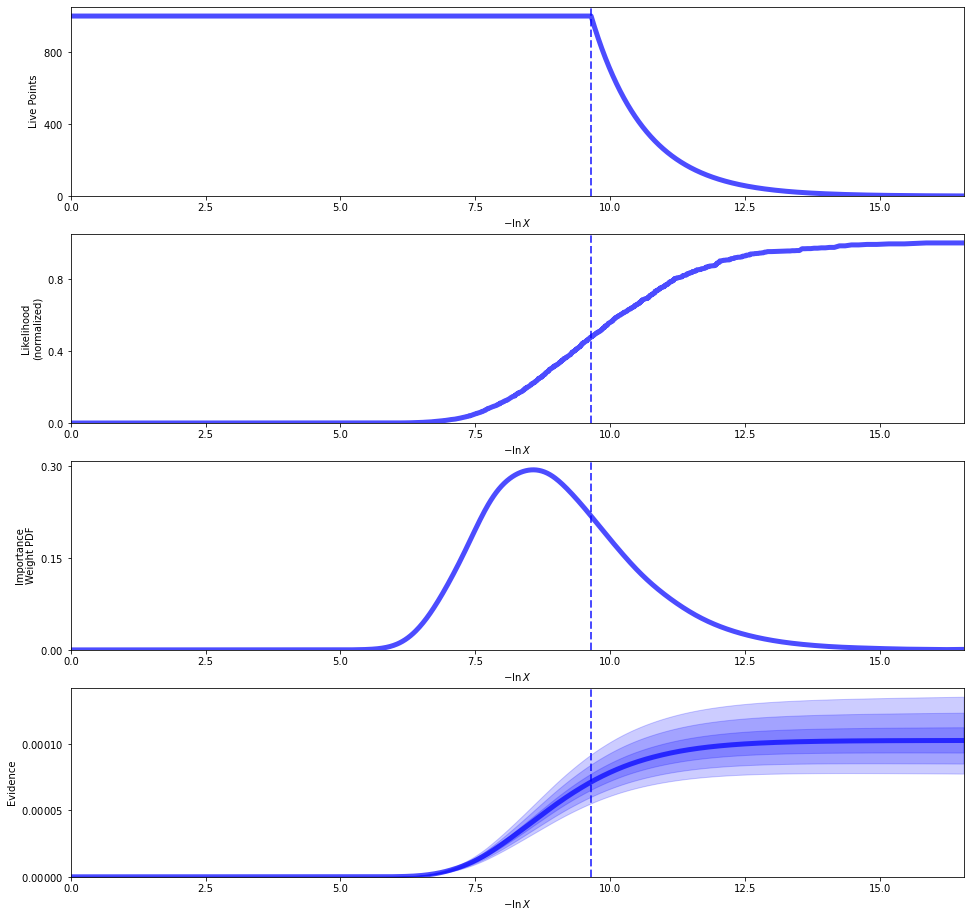

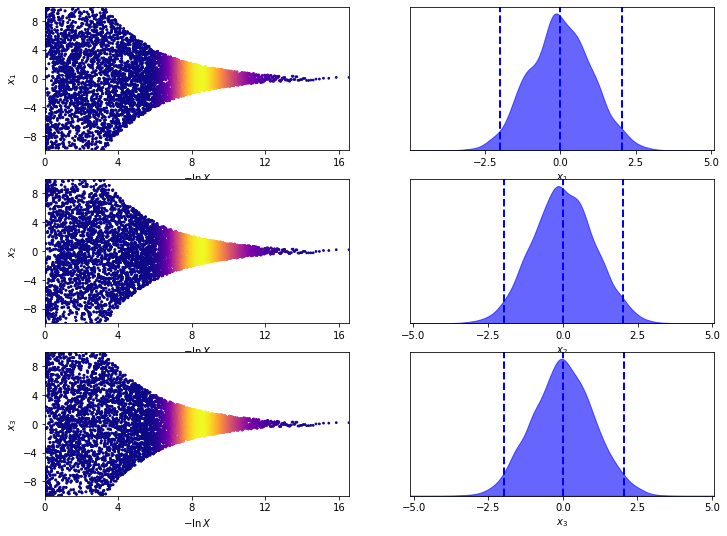

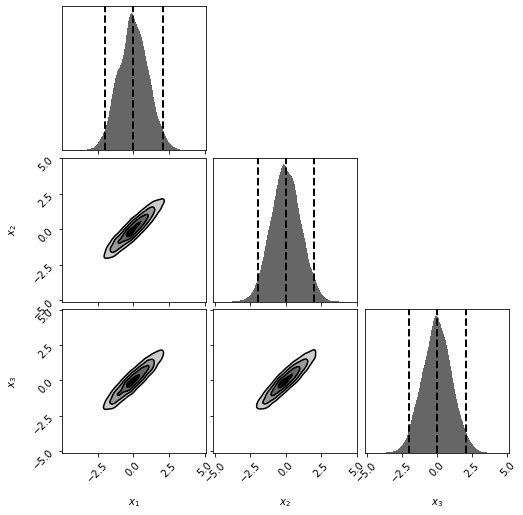

In [5]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(results)

tfig, taxes = dyplot.traceplot(results)

cfig, caxes = dyplot.cornerplot(results)

On peut ensuite analyser et traiter les données (_post-processing_). Par exemple:

In [8]:
from dynesty import utils as dyfunc

# Extraction des résultats
samples = results.samples  # échantillons
weights = np.exp(results.logwt - results.logz[-1])  # poids normalizés

# quantiles pour 10%-90%
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Moyenne et covariance pondérées
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Re-échantillonnage
samples_equal = dyfunc.resample_equal(samples, weights)

# Nouvel ensemble de résultats avec les incertitudes statistiques et les incertitudes d'échantillonage
results_sim = dyfunc.simulate_run(results)

In [7]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:

